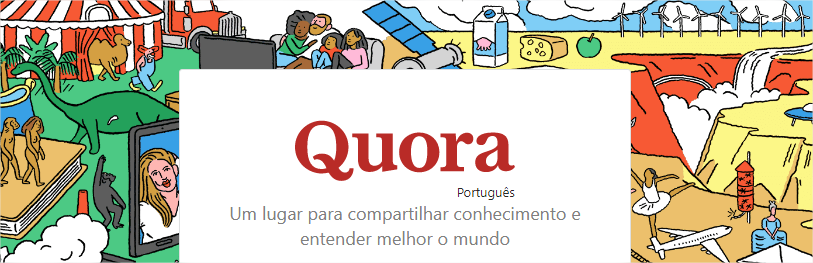

**Avaliação de Similaridades entre perguntas no Quora.**

Quora é uma plataforma de perguntas e respostas onde as perguntas são feitas, respondidas, editadas e organizadas por sua comunidade de usuários.

#### IMPORTAÇÃO DAS BIBLIOTECAS

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers

import tensorflow as tf


tqdm.pandas()
pd.options.display.max_colwidth = None
sns.set_style('darkgrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
!pip install tfa-nightly

#### LEITURA DOS ARQUIVOS DO QUORA (Dataset Kaggle)

###### Leitura dos Arquivo de Treino

In [50]:
## dados de Treino
dadosTreino = pd.read_csv('reduzed_train.csv')
print(dadosTreino.shape)
dadosTreino.columns =['id', 'qid1','qid2','Questao1','Questao2', 'Duplicada']


(208968, 6)


##### Leitura dos Arquivo de Teste

In [51]:
## dados de Teste
dadosTeste = pd.read_csv('reduzed_test.csv')
dadosTeste.columns =['id', 'qid1','qid2','Questao1','Questao2', 'Duplicada']
print(dadosTeste.shape)


(89558, 6)


#### AVALIAÇÃO DO BALANCEAMENTO DAS CLASSES

In [52]:
Duplicada = dadosTreino[dadosTreino['Duplicada']==1]
NaoDuplicada = dadosTreino[dadosTreino['Duplicada']==0]

Frames = (Duplicada, NaoDuplicada)
dadosTreino = pd.concat(Frames)

print("-------- RESUMO DOS DADOS DE TREINO -----------------\n")
print("Quantidade de Colunas: {}".format(dadosTreino.shape[1]))
print("Quantidade de Registros: {}".format(dadosTreino.shape[0]))


print("\n-------- RESUMO DOS DADOS DE TESTE -----------------\n")
print("Quantidade de Colunas: {}".format(dadosTeste.shape[1]))
print("Quantidade de Registros: {}".format(dadosTeste.shape[0]))


print("\n\n-------- EQUILIBRIO DAS CLASSES DE TREINO -----------------\n")
print("Questões Duplicadas: {} %".format(100-round(dadosTreino['Duplicada'].mean()*100,2)))
print("Questões Não Duplicadas {} %".format(round(dadosTreino['Duplicada'].mean()*100,2)))

print("\n")

-------- RESUMO DOS DADOS DE TREINO -----------------

Quantidade de Colunas: 6
Quantidade de Registros: 208968

-------- RESUMO DOS DADOS DE TESTE -----------------

Quantidade de Colunas: 6
Quantidade de Registros: 89558


-------- EQUILIBRIO DAS CLASSES DE TREINO -----------------

Questões Duplicadas: 49.98 %
Questões Não Duplicadas 50.02 %




1    0.500191
0    0.499809
Name: Duplicada, dtype: float64


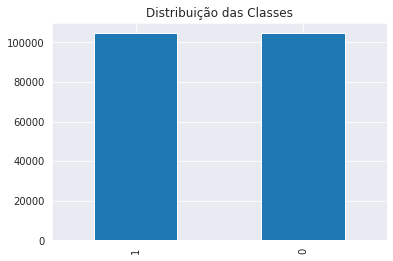

In [53]:
# Os dados precisam estar com as classes de treino balanceados
ValoresDuplicados = dadosTreino.Duplicada.value_counts()

print(ValoresDuplicados/ValoresDuplicados.sum())

plt.title('Distribuição das Classes')
ValoresDuplicados.plot.bar()

In [54]:
Questoes=pd.Series(dadosTreino['Questao1'].tolist() + dadosTreino['Questao2'].tolist())

QuantidadeIds = len(np.unique(Questoes.tolist()))
QuestoesRepetidas = np.sum(Questoes.value_counts()>1)

print ('Quantidade de Questões: {}\n'.format(QuantidadeIds))

print ('Questões Repetidas: {} ({}%)\n'.format(QuestoesRepetidas,round(QuestoesRepetidas/QuantidadeIds*100,2)))

print ('Número Máximo das Questões que mais se repetem: {}\n'.format(max(Questoes.value_counts()))) 

Questoes = pd.DataFrame({'Questoes':Questoes})

Quantidade de Questões: 292591

Questões Repetidas: 52615 (17.98%)

Número Máximo das Questões que mais se repetem: 74



#### VETORIZAÇÃO

In [55]:
# Criação de um array com os indices
train_index = dadosTreino.index.tolist()
valid_index = dadosTreino.index.tolist()

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=1,
    max_df=1.0,
    sublinear_tf=True
).fit(Questoes['Questoes'].fillna('').values)

#Treinamento
x_train = dadosTreino[['Questao1', 'Questao2']].iloc[train_index].reset_index(drop=True)
y_train = dadosTreino['Duplicada'].iloc[train_index].reset_index(drop=True).values

#Dados Validação
x_valid = dadosTreino[['Questao1', 'Questao2']].iloc[valid_index].reset_index(drop=True)
y_valid = dadosTreino['Duplicada'].iloc[valid_index].reset_index(drop=True).values

y_train.shape, y_valid.shape


((208968,), (208968,))

##### PREPARA OS TENSORES PARA O TREINO

In [56]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [57]:

from scipy import sparse

#Baseados nos dados de TREINO
x_train_1 = vectorizer.transform(x_train['Questao1'].fillna(''))
x_train_2 = vectorizer.transform(x_train['Questao2'].fillna(''))
x_train = [sparse_tensor(x_train_1), sparse_tensor(x_train_2)]

x_valid_1 = vectorizer.transform(x_valid['Questao1'].fillna(''))
x_valid_2 = vectorizer.transform(x_valid['Questao2'].fillna(''))
x_valid = [sparse_tensor(x_valid_1), sparse_tensor(x_valid_2)]

x = [
    sparse_tensor(sparse.vstack([x_train_1, x_valid_1])), 
    sparse_tensor(sparse.vstack([x_train_2, x_valid_2]))
]
y = np.concatenate([y_train, y_valid])

del x_train_1, x_train_2, x_valid_1, x_valid_2

x_train[0].shape, x_valid[0].shape

(TensorShape([208968, 59608]), TensorShape([208968, 59608]))

##### PREPARA OS TENSORES PARA O TESTE

In [58]:
#Baseado nos dados TESTE
x_test_1 = vectorizer.transform(dadosTeste['Questao1'].fillna(''))
x_test_2 = vectorizer.transform(dadosTeste['Questao2'].fillna(''))
x_test = [sparse_tensor(x_test_1), sparse_tensor(x_test_2)]
x_test[0].shape

TensorShape([89558, 59608])

In [59]:
class BuscaSimilar(Model):
    def __init__(self, inputShape, featExtractorConfig):
        super(BuscaSimilar, self).__init__()
        
        inpA = layers.Input(shape=inputShape)
        inpB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, featExtractorConfig)
        featsA = featureExtractor(inpA)
        featsB = featureExtractor(inpB)
        distance = layers.Concatenate()([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[inpA, inpB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, featExtractorConfig):
        
        layers_config = [layers.Input(inputShape)]
        for i, n_units in enumerate(featExtractorConfig):
            layers_config.append(layers.Dense(n_units))
            layers_config.append(layers.Dropout(0.35))
            layers_config.append(layers.BatchNormalization())
            layers_config.append(layers.Activation('relu'))
        
        model = Sequential(layers_config, name='feature_extractor')

        return model  
        
    def call(self, x):
        return self.model(x)

In [60]:

import tensorflow_addons as tfa

model = BuscaSimilar(inputShape=x_train[0].shape[1], featExtractorConfig=[64])
model.compile(
    loss="binary_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy", tfa.metrics.F1Score(num_classes=2, average="micro")]
)

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                3814976   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
Total params: 3,815,232
Trainable params: 3,815,104
Non-trainable params: 128
_________________________________________________________________
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer

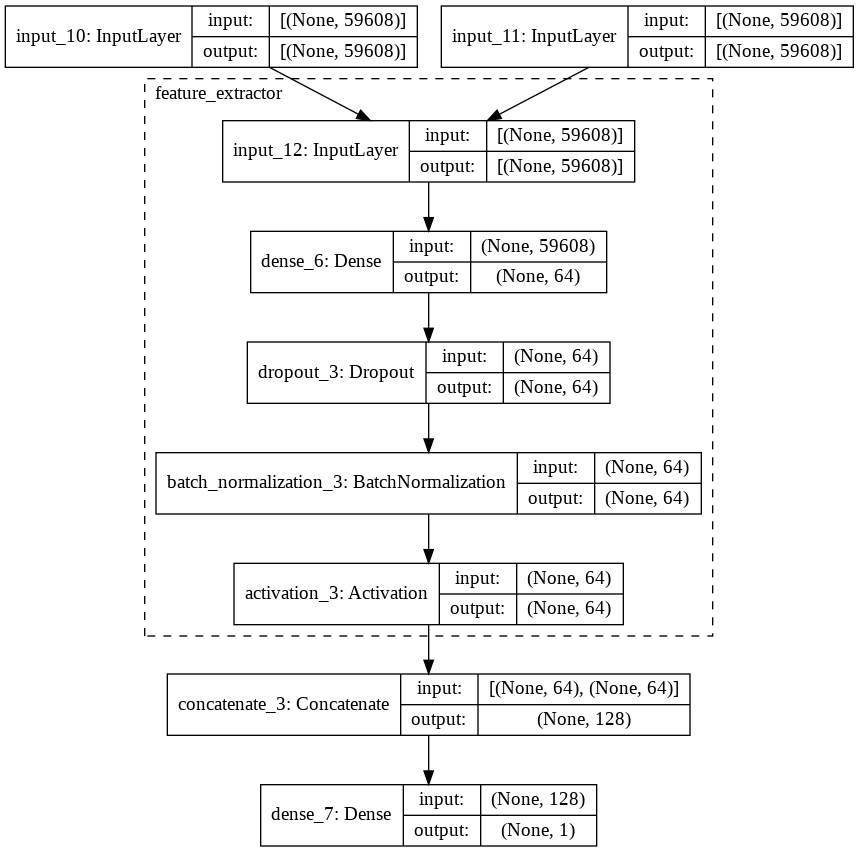

In [61]:
model.model.layers[2].summary()
model.model.summary()
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

#### REALIZAR O TREINAMENTO DO MODELO

In [71]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, mode='auto', verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=64, 
    epochs=20,
    callbacks=[es, rlp]
)


Epoch 1/20
3266/3266 [==============================] - 140s 43ms/step - loss: 0.2015 - accuracy: 0.9136 - f1_score: 0.6674 - val_loss: 0.1369 - val_accuracy: 0.9546 - val_f1_score: 0.6670
Epoch 2/20
3266/3266 [==============================] - 146s 45ms/step - loss: 0.1940 - accuracy: 0.9174 - f1_score: 0.6676 - val_loss: 0.1368 - val_accuracy: 0.9535 - val_f1_score: 0.6671
Epoch 3/20
3266/3266 [==============================] - 141s 43ms/step - loss: 0.1894 - accuracy: 0.9191 - f1_score: 0.6676 - val_loss: 0.1295 - val_accuracy: 0.9568 - val_f1_score: 0.6670
Epoch 4/20
3266/3266 [==============================] - 144s 44ms/step - loss: 0.1834 - accuracy: 0.9231 - f1_score: 0.6678 - val_loss: 0.1237 - val_accuracy: 0.9594 - val_f1_score: 0.6671
Epoch 5/20
3266/3266 [==============================] - 139s 42ms/step - loss: 0.1805 - accuracy: 0.9233 - f1_score: 0.6678 - val_loss: 0.1093 - val_accuracy: 0.9650 - val_f1_score: 0.6673
Epoch 6/20
3266/3266 [==============================] -

#### AVALIAÇÃO DAS MÉTRICAS DO MODELO TREINADO

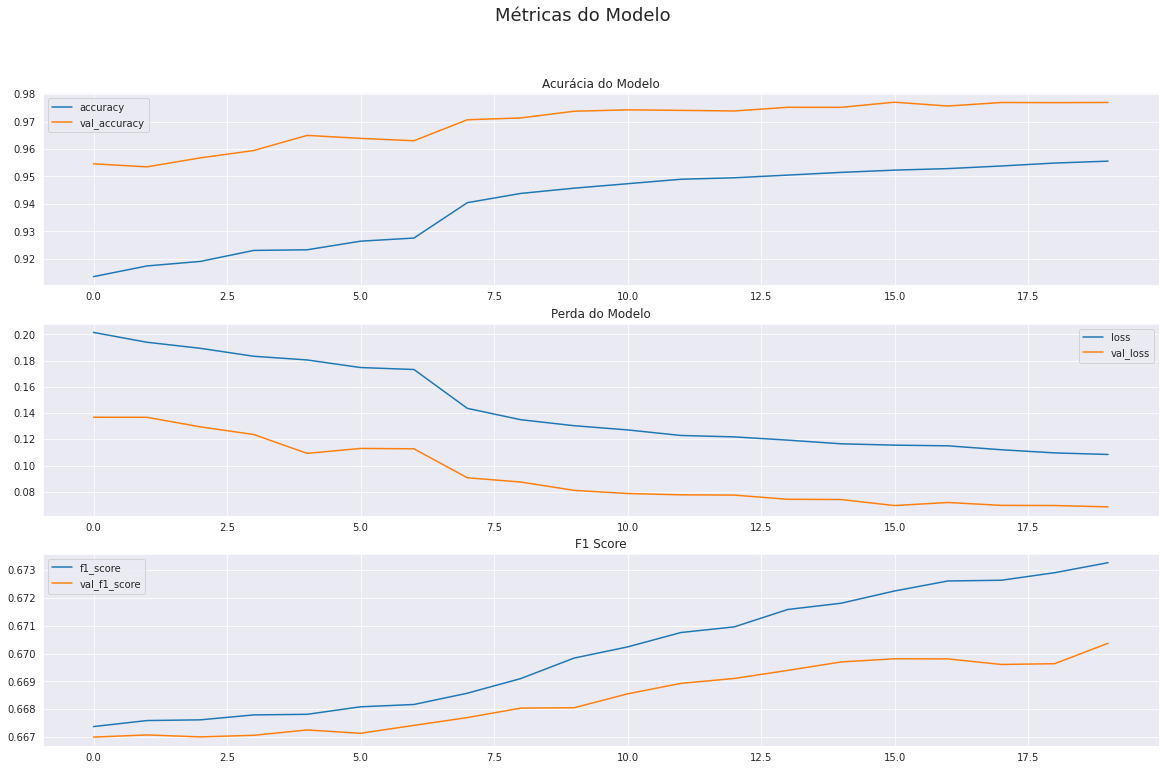

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(20, 12))
df = pd.DataFrame(history.history)

ax[0].set_title('Acurácia do Modelo', fontsize=12)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])

ax[1].set_title('Perda do Modelo', fontsize=12)
df[['loss', 'val_loss']].plot(ax=ax[1])

ax[2].set_title('F1 Score', fontsize=12)
df[['f1_score', 'val_f1_score']].plot(ax=ax[2])

fig.suptitle('Métricas do Modelo', fontsize=18);

##### DADOS DO MODELO

In [73]:
df = pd.DataFrame(history.history)
df

,loss,accuracy,f1_score,val_loss,val_accuracy,val_f1_score,lr
0,0.201526,0.913561,0.667382,0.136866,0.954620,0.667005,0.010
1,0.194030,0.917447,0.667597,0.136841,0.953510,0.667081,0.010
2,0.189421,0.919093,0.667623,0.129538,0.956778,0.667011,0.010
3,0.183359,0.923093,0.667800,0.123702,0.959448,0.667069,0.010
4,0.180549,0.923328,0.667821,0.109321,0.964961,0.667260,0.010
5,0.174754,0.926458,0.668090,0.113081,0.963875,0.667141,0.010
6,0.173268,0.927597,0.668173,0.112808,0.963009,0.667424,0.010
7,0.143650,0.940469,0.668577,0.090730,0.970646,0.667704,0.002
8,0.134985,0.943838,0.669101,0.087476,0.971311,0.668043,0.002
9,0.130409,0.945752,0.669837,0.081114,0.973747,0.668056,0.002


#### PREDIÇÃO - COM BASE NOS DADOS RESERVADOS PARA TESTES

##### PREDIÇÃO

In [100]:
y_pred=model.predict(x_test)
y_pred = y_pred.round()

##### MATRIZ DE CONFUSÃO

In [101]:
y_Real = dadosTeste['Duplicada']
y_Real = y_Real.fillna(0)
MatrizConfusao = confusion_matrix(y_Real, y_pred)
MatrizConfusao

array([[35758,  9061],
       [12955, 31784]])

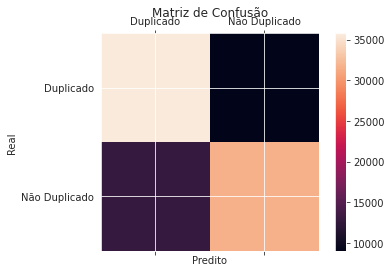

In [76]:
fig = plt.figure()

labels = ['Duplicado', 'Não Duplicado']

ax = fig.add_subplot(111)
cax = ax.matshow(MatrizConfusao)

plt.title('Matriz de Confusão')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [77]:
MatrizConfusao

array([[35758,  9061],
       [12955, 31784]])

In [78]:
# Levantamento dos Valores da Matriz de Confusão

VerdadeiroPositivo = MatrizConfusao[0][0]
FalsoPositivo = MatrizConfusao[0][1]

FalsoNegativo = MatrizConfusao[1][0]
VerdadeiroNegativo = MatrizConfusao[1][1]


##### APRESENTAÇÃO DAS MÉTRICAS

In [79]:
Acuracia = round((VerdadeiroPositivo + VerdadeiroNegativo) / (VerdadeiroPositivo+VerdadeiroNegativo+FalsoPositivo+FalsoNegativo) ,6)
print('Acurácia: ', Acuracia)

Recall = round((VerdadeiroPositivo) / (VerdadeiroPositivo+FalsoNegativo),6)
print('Recall  : ', Recall )

Precisao = round((VerdadeiroPositivo) / (VerdadeiroPositivo+FalsoPositivo),6)
print('Precisão: ', Precisao)

FScore = round((2 * (Precisao * Recall)/(Precisao+Recall)),6)
print('F-Score : ', FScore)


Acurácia:  0.75417
Recall  :  0.734055
Precisão:  0.797831
F-Score :  0.764615
